# GETTIN
## Planejamento de Equipamentos Escolares
## Método: k-Median Facility Location
### Versão: 2.0
#### Fillipe O Feitosa <fillipefeitosa@ua.pt>

---


\begin{split}& \mbox{minimize} \quad    & \sum_{i=1}^n \sum_{j=1}^m d_{ij} y_{ij} &     \\
& \mbox{subject to:} \quad & \sum_{j=1}^m y_{ij} =1 &  \mbox{ for } i=1,\cdots,n\\
&   & \sum_{j=1}^m x_{j} = k                        &   \\
&   & y_{ij} \leq x_j                               & \mbox{ for }  i=1,\cdots,n; j=1,\cdots,m  \\
&   & y_{ij} \in \{ 0,1 \}                          & \mbox{ for }  i=1,\cdots,n; j=1,\cdots,m \\
&   & x_j \in \{ 0,1 \}                             & \mbox{ for }  j=1,\cdots,m\end{split}

\begin{split}&   & \sum_{i=1}^{n} y_{ij} \leq y_j,                               & \mbox{ for }  j=1,\cdots,m.  \\\end{split}

#### Modeling and Creating Decision Variables

In [1]:
# Import Libraries
from gurobi import *
import math
import matplotlib.pyplot as plt

# Used to Create Visualization
from geojson import Feature, Point, FeatureCollection
import geopandas as gpd
import geojson

def distance(a,b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return math.sqrt(dx*dx + dy*dy)

# Data
# Problem data

k = int(input("Provide a Int K: "))

vagos = gpd.read_file('./data_gettin/vagos.geojson')
centroids = vagos.centroid

iteratorHandler = centroids.size
centroidVector = []
for centroid in centroids:
    obj = [centroid.xy[0][0], centroid.xy[1][0]]
    centroidVector.append(obj)

subSections = centroidVector
schools = centroidVector
# @charge: custo de construcao por escola (fixo em 500 mil euros)
# charge = 5000000

numSchools = len(schools)
numSubSections = len (subSections)

# Creting Guroby Model
m = Model()

# Decision Variables
x = {}
y = {}
d = {} # Distance Matrix
# @alpha: 0.29 de custo por Km  por (365 dias * 5 anos) 
# alpha = 529.25

# creating binary variable for every school
for j in range(numSchools):
    x[j] = m.addVar(obj=0, vtype=GRB.BINARY, name="%d" % j)

# creating continuous variable for subsections to check suply fractions
for i in range(numSubSections):
    for j in range(numSchools):
        # Distances between Subsections and Schools
        d[(i,j)] = distance(subSections[i], schools[j])
        # Fractions of Subsection Suply
        y[(i,j)] = m.addVar(obj=d[i,j], vtype=GRB.BINARY, name="Fração da Sub[%d], escola[%d]" % (i,j))
        

m.update()

/home/fillipe/anaconda3/envs/pandas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Provide a Int K: 10


In [2]:
subSections

[[-8.66377668296862, 40.43498978403321],
 [-8.667266486223651, 40.434720252768344],
 [-8.762815602291013, 40.56397304188675],
 [-8.764141525766831, 40.562949678516226],
 [-8.761782210224224, 40.56368107940843],
 [-8.762049921724474, 40.56379714921472],
 [-8.742376902561267, 40.57696080731299],
 [-8.748642886216743, 40.573450274781074],
 [-8.759863961411654, 40.57320586179287],
 [-8.716327217900835, 40.4775963570931],
 [-8.690630621526843, 40.50413584930182],
 [-8.688997639405068, 40.50654388167653],
 [-8.687761244402779, 40.50684770589882],
 [-8.686066040871214, 40.50796901218898],
 [-8.671836368711876, 40.50576903457918],
 [-8.684470918011062, 40.50300020685901],
 [-8.687153559439174, 40.50789112786155],
 [-8.689030544435754, 40.507955092095806],
 [-8.671947973431696, 40.50870248053603],
 [-8.686069364314765, 40.50891557287068],
 [-8.67537725889719, 40.506690506352165],
 [-8.688072569219758, 40.50904139035364],
 [-8.690609013605036, 40.50849918664833],
 [-8.676091645176031, 40.5095078

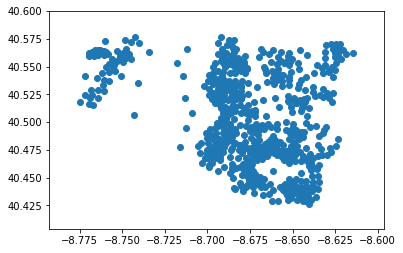

In [3]:
plt.scatter(*zip(*subSections))
plt.show()

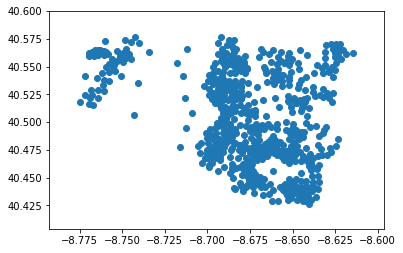

In [4]:
plt.scatter(*zip(*schools))
plt.show()

## Adding Constraints

In [5]:
# Constraint for Every Student on School
# for i in range(numSubSections):
#     m.addConstr(quicksum(y[(i,j)] for j in range(numSchools)) == 1)

# Fraction of suply must be lower or equal than the BINARY x[j] available 
# for i in range(numSubSections):
#     for j in range(numSchools):
#         m.addConstr(y[(i,j)] <= x[j])

for i in range(numSubSections):
    coef = [1 for j in range(numSchools)]
    var = [y[i,j] for j in range(numSchools)]
    m.addConstr(LinExpr(coef,var), "=", 1, name="Assign[%s]"%i)

for j in range(numSchools):
    for i in range(numSubSections):
        m.addConstr(y[i,j], "<", x[j], name="Strong[%s,%s]"%(i,j))

coef = [1 for j in range(numSchools)]
var = [x[j] for j in range(numSchools)]
m.addConstr(LinExpr(coef,var), "=", rhs=k, name="k_median")

<gurobi.Constr *Awaiting Model Update*>

#### Objetive


In [6]:
# Setting objective

m.setObjective(quicksum(d[(i,j)]*y[(i,j)] for i in range(numSubSections) for j in range(numSchools)), GRB.MINIMIZE)


m.optimize()

Optimize a model with 480943 rows, 480942 columns and 1441440 nonzeros
Variable types: 0 continuous, 480942 integer (480942 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve time: 5.28s
Presolved: 480943 rows, 480942 columns, 1441440 nonzeros
Variable types: 0 continuous, 480942 integer (480942 binary)
Found heuristic solution: objective 31.7125361

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Presolved: 480943 rows, 480942 columns, 1441440 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1712536e+01   0.000000e+00   3.824157e+03      9s
   48168    3.1124829e+01   0.000000e+00   4.455046e+03     10s
  176647    1.8248631e+01   0.000000e+00   1.446628e+04     15s
  183867    1.7771874e+01   0.00

In [7]:
m

<gurobi.Model MIP instance Unnamed: 480943 constrs, 480942 vars, Parameter changes: LogFile=gurobi.log, CSIdleTimeout=1800>

In [8]:
print('Obj: %g' % m.objVal)

Obj: 8.22917


In [9]:
# Added @listOfResults to generate visualization

for v in m.getVars():
    if(v.x != 0):
        print('%s   %g' % (v.varName, v.x))

15   1
119   1
130   1
313   1
327   1
396   1
426   1
440   1
589   1
643   1
Fração da Sub[0], escola[589]   1
Fração da Sub[1], escola[643]   1
Fração da Sub[2], escola[440]   1
Fração da Sub[3], escola[440]   1
Fração da Sub[4], escola[440]   1
Fração da Sub[5], escola[440]   1
Fração da Sub[6], escola[440]   1
Fração da Sub[7], escola[440]   1
Fração da Sub[8], escola[440]   1
Fração da Sub[9], escola[327]   1
Fração da Sub[10], escola[15]   1
Fração da Sub[11], escola[15]   1
Fração da Sub[12], escola[15]   1
Fração da Sub[13], escola[15]   1
Fração da Sub[14], escola[15]   1
Fração da Sub[15], escola[15]   1
Fração da Sub[16], escola[15]   1
Fração da Sub[17], escola[15]   1
Fração da Sub[18], escola[15]   1
Fração da Sub[19], escola[15]   1
Fração da Sub[20], escola[15]   1
Fração da Sub[21], escola[15]   1
Fração da Sub[22], escola[15]   1
Fração da Sub[23], escola[15]   1
Fração da Sub[24], escola[15]   1
Fração da Sub[25], escola[15]   1
Fração da Sub[26], escola[15]   1
Fra

Fração da Sub[448], escola[440]   1
Fração da Sub[449], escola[440]   1
Fração da Sub[450], escola[426]   1
Fração da Sub[451], escola[440]   1
Fração da Sub[452], escola[426]   1
Fração da Sub[453], escola[426]   1
Fração da Sub[454], escola[440]   1
Fração da Sub[455], escola[440]   1
Fração da Sub[456], escola[440]   1
Fração da Sub[457], escola[396]   1
Fração da Sub[458], escola[396]   1
Fração da Sub[459], escola[440]   1
Fração da Sub[460], escola[440]   1
Fração da Sub[461], escola[426]   1
Fração da Sub[462], escola[440]   1
Fração da Sub[463], escola[426]   1
Fração da Sub[464], escola[440]   1
Fração da Sub[465], escola[440]   1
Fração da Sub[466], escola[440]   1
Fração da Sub[467], escola[440]   1
Fração da Sub[468], escola[396]   1
Fração da Sub[469], escola[440]   1
Fração da Sub[470], escola[119]   1
Fração da Sub[471], escola[426]   1
Fração da Sub[472], escola[426]   1
Fração da Sub[473], escola[426]   1
Fração da Sub[474], escola[426]   1
Fração da Sub[475], escola[4

In [10]:
# How to retrieve variables from the Model by Name
# int(m.getVarByName("19").varName)

# Used to get the Index of Schools from the M Model Optimized
listOfResults = []
for e in range(numSchools):
    tempObj = m.getVarByName(str(e))
    # If This School is on the Results Optimized
    if(tempObj.x != 0):
        listOfResults.append(int(tempObj.varName))
        
# Select, from the List Of Results, A set of Centroid Points 
listOfPoints = []
for schoolNumber in listOfResults:
    # Attention to the Feature(geometry) from geopandas
    listOfPoints.append(Feature(geometry=centroids[schoolNumber]))

# Creating a FeatureCollection with the Features (Points) manipulated above
resultCentroids = FeatureCollection(listOfPoints)

In [11]:
# Write Feature Collection to GeoJson File
dump = geojson.dumps(resultCentroids, sort_keys=True)
with open('./data_gettin/k-median-%d.geojson' % k, 'w') as outfile:
      geojson.dump(resultCentroids, outfile)

In [12]:
m = None

In [13]:
disposeDefaultEnv()